In [1]:
from lsst_efd_client import EfdClient
from lsst.ts import salobj

import asyncio
import numpy as np
import os, glob
import time
import ast

from astropy.io import fits
import matplotlib.pyplot as plt

from scipy import interpolate
from scipy import stats
from scipy.optimize import curve_fit

from astropy.time import Time, TimeDelta
import pandas as pd

from scipy.interpolate import RBFInterpolator

In [2]:
scan_files = glob.glob('/home/parfa30/DATA/ScanData/*.fits')

In [15]:
scan_files = np.sort(scan_files)
print(scan_files)

['/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-15T16:15:51.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-16T17:52:42.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-16T21:08:52.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-17T15:39:14.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-06-20T16:17:05.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-06T23:11:28.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-07T17:39:37.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-07T23:10:33.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-12T20:59:25.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-13T20:26:00.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-14T23:36:00.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-20T00:16:19.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-07-21T21:32:56.fits'
 '/home/parfa30/DATA/ScanData/CIMACS_full_scan_2022

In [4]:
len(scan_files)

18

In [20]:
hdu = fits.open(scan_files[-1])
hdu.info()

Filename: /home/parfa30/DATA/ScanData/CIMACS_full_scan_2022-08-05T23:51:24.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  2             1 BinTableHDU     27   275R x 9C   [D, D, D, D, D, D, D, D, D]   
  2  4             1 BinTableHDU     27   275R x 9C   [D, D, D, D, D, D, D, D, D]   


In [21]:
elec_2 = hdu['2'].data
elec_4 = hdu['4'].data
#elec_5 = hdu['5'].data

In [7]:
# for 740nm only
elec_4 = elec_4[elec_4.X < 1400]

(1300.0, 100.0)

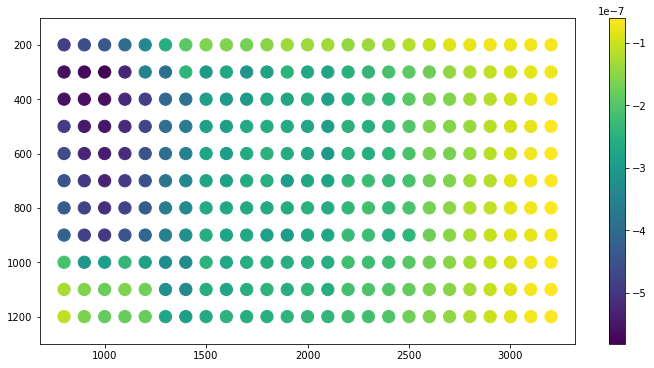

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(elec_2.X,elec_2.Y, c=elec_2.MEAN, s=150)
plt.colorbar()
plt.ylim(1300, 100)

(1300.0, 100.0)

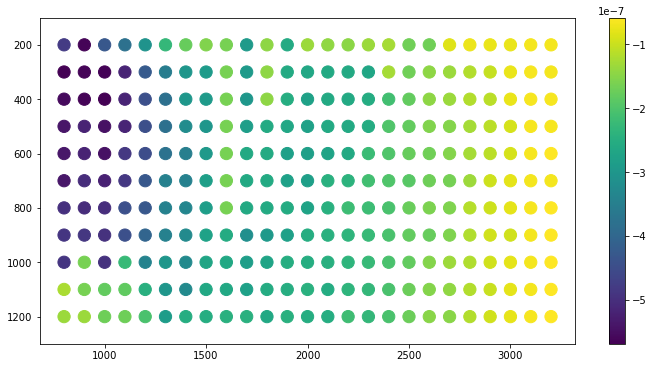

In [23]:
plt.figure(figsize=(12,6))
plt.scatter(elec_4.X,elec_4.Y, c=elec_4.MEAN, s=150)
plt.colorbar()
plt.ylim(1300, 100)

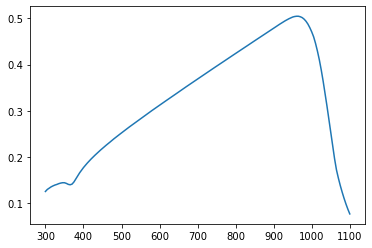

In [9]:
df = pd.read_csv('../hamamatsu_responsivity.csv')
plt.plot(df.wavelength, df.responsivity)

f = interpolate.interp1d(list(df.wavelength), list(df.responsivity))
def watts_per_mm2(amps,wl):
    area = 10**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2
def watts_per_cm2(amps,wl):
    print(f(wl))
    area = 1**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2

(1300.0, 100.0)

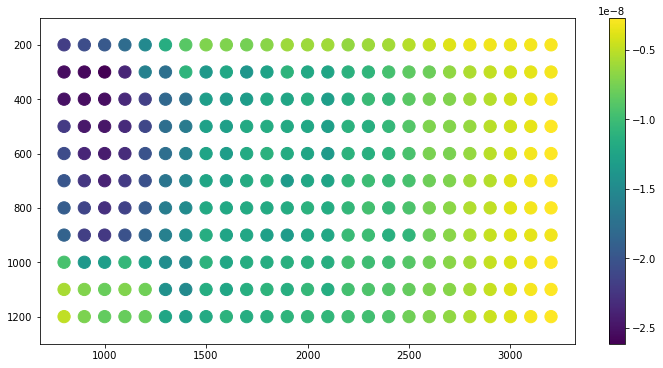

In [12]:
plt.figure(figsize=(12,6))
zz = watts_per_mm2(elec_2.MEAN, 455)
plt.scatter(elec_2.X,elec_2.Y, c=zz, s=150)
plt.colorbar()
plt.ylim(1300, 100)

(-1.1041938745658835e-08, 5.760507741095086e-09)

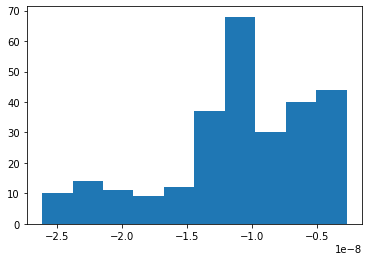

In [14]:
plt.hist(zz)
np.mean(zz), np.std(zz)

In [28]:
def combine_elec_data(list_of_elec_data):
    num = ast.literal_eval(hdu[0].header['ELEC'])
    fig, axarr = plt.subplots(1, len(num), figsize=(15,6))
    ax = axarr.ravel()
    zes = []
    for i, elec in enumerate(list_of_elec_data):
        x = elec.X+hdu[0].header['{}_OFFSET'.format(num[i])]
        y = elec.Y
        z = elec.MEAN

        #f = interpolate.interp2d(x, y, z, kind='linear', bounds_error=False, fill_value=np.nan)
        binx = np.linspace(300, 3300, (3300-300))
        biny = np.linspace(200, 1500, (1500-200))
        val,xedge,yedge,binn = stats.binned_statistic_2d(x, y, z, 'mean', bins=[binx, biny])
        zes.append(val.T)
        xx,yy = np.meshgrid(xedge[:-1],yedge[:-1])
        
        
        ax[i].scatter(xx,yy,c=val.T,s=50)
        ax[i].set_title('Electrometer {}'.format(num[i]))

       
    n = np.nanmean(zes, axis=0)
    n = n.reshape(xx.shape)

    X = xx.flatten()
    Y = yy.flatten()
    Z = n.flatten()*-1

    X = X[~np.isnan(Z)]
    Y = Y[~np.isnan(Z)]
    Z = Z[~np.isnan(Z)]
    plt.figure()
    plt.scatter(X,Y,c=Z)
    plt.colorbar()
    
    plt.figure(figsize=(10,10))
    ax = plt.axes(projection = '3d')
    ax.plot_trisurf(xx[~np.isnan(n)],yy[~np.isnan(n)],n[~np.isnan(n)]*-1,cmap = 'viridis')
    
    return X, Y, Z

In [7]:
def interpolate_data(X, Y, Z):
    scattered_points = np.stack([X, Y],-1)
    XX = np.linspace(300, 1600,(1600-300))
    YY = np.linspace(200, 1500,(1500-200))
    x_dense, y_dense = np.meshgrid(XX,YY)
    dense_points = np.stack([x_dense.ravel(), y_dense.ravel()], -1)

    interpolation = RBFInterpolator(scattered_points, Z, kernel='linear',epsilon=1, degree=0)
    z_dense = interpolation(dense_points).reshape(x_dense.shape)
    
    plt.figure()
    plt.scatter(x_dense, y_dense, c=z_dense ,cmap='viridis', edgecolor='none')
    
    X = x_dense.flatten()
    Y = y_dense.flatten()
    Z = z_dense.flatten()
   
    return X, Y, Z

In [10]:
def gaussian(x, a, b, sigma, c):
    val = a * np.exp(-(x - b)**2 / (2*sigma**2)) + c
    return val

In [11]:
def center_data(x_guess, y_guess, X, Y, Z, fit=True):
    center_y_approx = np.where(np.abs(Y-y_guess)<1)

    if fit:
        
        idx = np.where((X[center_y_approx]>800)&(X[center_y_approx]<1300))
        xxx = X[center_y_approx][idx]
        yyy = Z[center_y_approx][idx]

        popt, pcov = curve_fit(gaussian, xxx, yyy,p0=[.00001,x_guess,100,2.5e-5])

        fig, ax = plt.subplots()
        ax.plot(xxx, yyy,c='C3')
        ax.plot(xxx, gaussian(xxx,*popt), '--', label='fit',c='C1')
        
        ax.axvline(popt[1], label='X center = {:.2f}'.format(popt[1]),c='C1')
        ax.set_xlabel("X axis @ y center")
        x_center = popt[1]

        center_x_approx = np.where(np.abs(X-x_center)<1)

        idx = np.where((Y[center_x_approx]>400)&(Y[center_x_approx]<900))
        xxx = Y[center_x_approx][idx]
        yyy = Z[center_x_approx][idx]

        popt, pcov = curve_fit(gaussian, xxx, yyy,p0=[.00001,y_guess,100,2.5e-5])
        ax.plot(xxx, yyy,c='C3')
        ax.plot(xxx, gaussian(xxx,*popt), '--', label='fit',c='C2')
        ax.axvline(popt[1], label='Y center = {:.2f}'.format(popt[1]),c='C2')
        ax.set_xlabel("Y axis @ x center")
        y_center = popt[1]
        ax.legend()
    
        X = X-x_center
        Y = Y-y_center
    else:
        X = X-x_guess
        Y = Y-y_guess
    
    circle = plt.Circle((0,0), 741.3/2.,fill=False, color='k')
    circle1 = plt.Circle((0,0), 326.8/2.,fill=False, color='k')
    fig, ax = plt.subplots(figsize=(8,6))

    p1 = ax.scatter(X,Y, c=Z ,cmap='viridis', edgecolor='none',s=100)
    ax.add_patch(circle)
    ax.add_patch(circle1)
    plt.colorbar(p1, ax=ax, label='Amps')
    ax.set_xlabel("X mm")
    ax.set_ylabel("Y mm")
    
    return X, Y, Z

In [20]:
def obs_plot(X,Y,Z):
    obsc_rad = 326.8/2.
    od_rad = 741.3/2.

    idx = np.where(np.sqrt(X**2 + Y**2)<obsc_rad)
    idy = np.where(np.sqrt(X**2 + Y**2)>od_rad)

    Z[idx] = np.nan
    Z[idy] = np.nan
    plt.figure(figsize=(8,6))
    zz = watts_per_mm2(Z, 445)
    plt.scatter(X, Y, c=zz, s=100)
    plt.colorbar(label="Watts/mm2")
    plt.title('{}; {}; {}; {}'.format(hdu[0].header['NAME'],hdu[0].header['SOURCE'],hdu[0].header['WAVE'],hdu[0].header['START']))
    plt.xlabel("X mm")
    plt.ylabel("Y mm")
    return X, Y, zz

/tmp/ipykernel_6154/870682204.py:23: RuntimeWarning: Mean of empty slice
  n = np.nanmean(zes, axis=0)


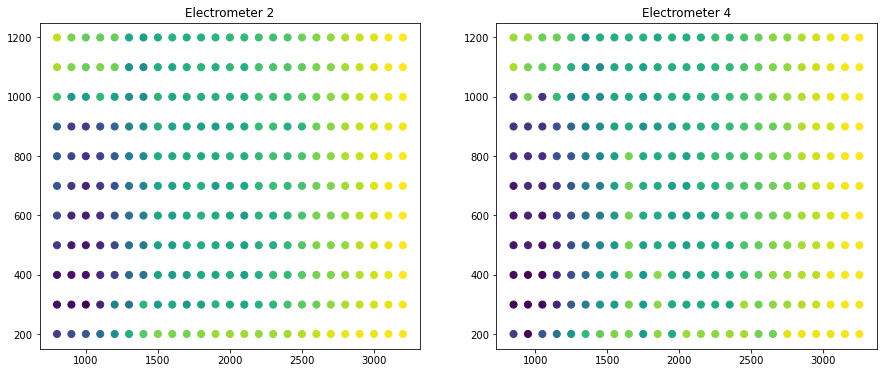

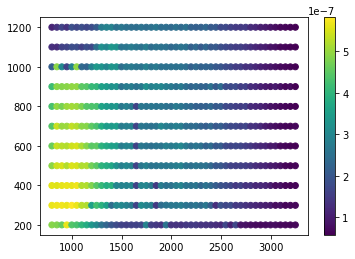

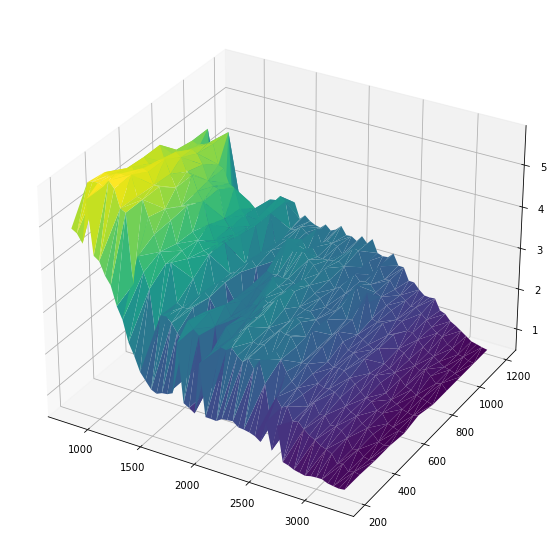

In [29]:
#445 nm
X, Y, Z = combine_elec_data([elec_2, elec_4])

(1300.0, 100.0)

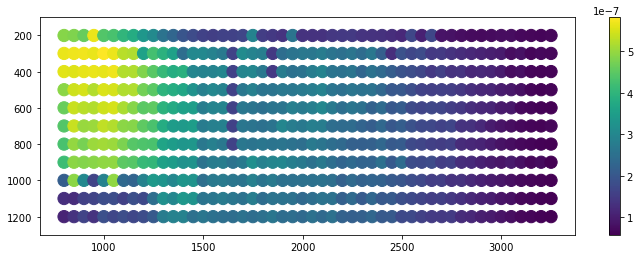

In [30]:
plt.figure(figsize=(12,4))
plt.scatter(X, Y, c=Z, s=150)
plt.colorbar()
plt.ylim(1300, 100)

Text(0.5, 1.0, 'Light measured at screen from Reflector (preliminary scan)')

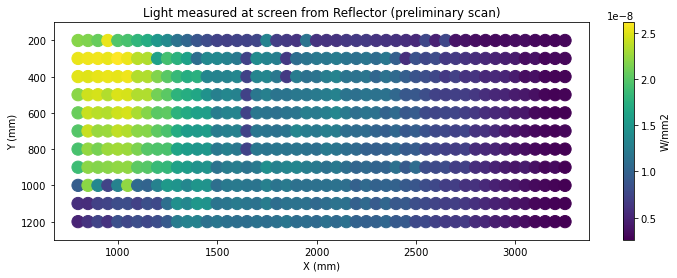

In [35]:
plt.figure(figsize=(12,4))
plt.scatter(X, Y, c=watts_per_mm2(Z, 455), s=150)
plt.colorbar(label='W/mm2')
plt.ylim(1300, 100)
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("Light measured at screen from Reflector (preliminary scan)")

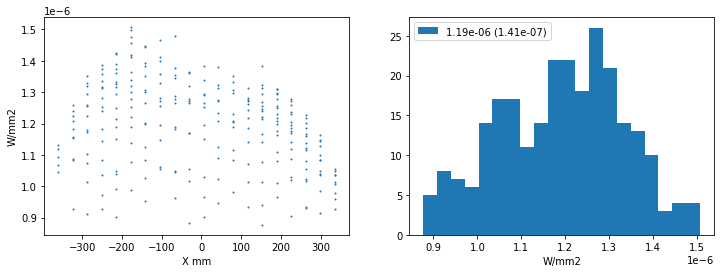

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.scatter(XX, ZZ,s=1)
ax1.set_xlabel('X mm')
ax1.set_ylabel('W/mm2')

ret = ax2.hist(ZZ,bins=20, label='{:.2e} ({:.2e})'.format(np.nanmean(ZZ), np.nanstd(ZZ)))
ax2.set_xlabel('W/mm2')
plt.legend()

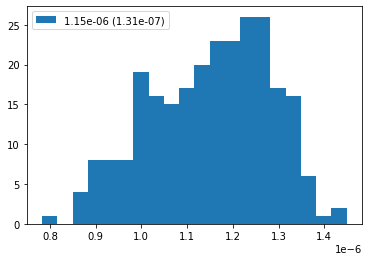

In [180]:
ret = plt.hist(zz,bins=20, label='{:.2e} ({:.2e})'.format(np.nanmean(zz), np.nanstd(zz)))
plt.legend()

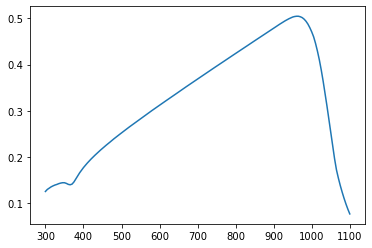

In [31]:
df = pd.read_csv('../hamamatsu_responsivity.csv')
plt.plot(df.wavelength, df.responsivity)

f = interpolate.interp1d(list(df.wavelength), list(df.responsivity))
def watts_per_mm2(amps,wl):
    area = 10**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2
def watts_per_cm2(amps,wl):
    print(f(wl))
    area = 1**2 #10mm^2
    watts = amps/f(wl)
    watts_per_mm2 = watts/area
    return watts_per_mm2

In [27]:
np.nanstd(zz)

9.970711543728633e-08

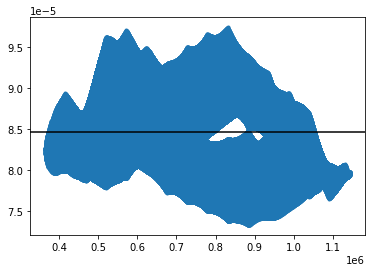

In [18]:
plt.plot(zz,'.')
plt.axhline(np.nanmean(zz),c='k')

0.2225


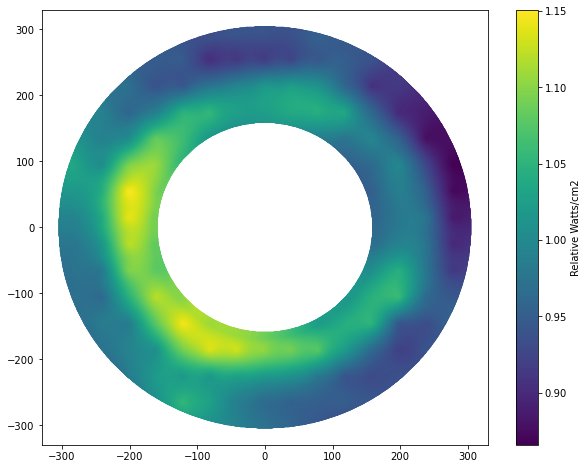

In [19]:
plt.figure(figsize=(10,8))
zz = watts_per_cm2(ZZ, 455)
plt.scatter(XX, YY, c=zz/float(np.nanmean(zz)))
plt.colorbar(label="Relative Watts/cm2")

In [2]:
np.nanstd(zz/float(np.nanmean(zz)))

NameError: name 'np' is not defined

In [33]:
np.nanmean(zz/float(np.nanmean(zz)))

1.0000000000000002

In [25]:
np.nanmean(zz)

2.292530078407259e-05